Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [17]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [19]:
model_name = 'mtm_3links'
model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Create joint variables and define their relations

In [20]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction |
|--------------|-----------|------------|-----|----------|-----|----------|--------------|---------------|---------|

In [21]:
#model_name = 'mtm'

_pi = sympy.pi

dh = []
springs = []
if model_name =='test':
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, False),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, False)]
    q = q1
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.067
    q_o = 23.0/180*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
elif model_name == 'mtm':
    # define paralelogram coordinate relation
    q3 = -q2 + q8
    q9 = -q8 + q2
    q10 = q8 - q2
    
    dh = [(0,   -1, [1],    0,     0,      0,        0,        False, False, False),
          (1,   0,  [2,8],  0,     0,      -0.21537, q1,       True,  False, True),
          (2,   1,  [3],    0,     -_pi/2, 0,        q2+_pi/2, True,  False, True),
          (3,   2,  [4],    0.279, 0,      0,        q3+_pi/2, True,  False, True),
          (4,   3,  [5],    0.365, -_pi/2, 0.151,    q4,       True,  False, True),
          (5,   4,  [6],    0,     _pi/2,  0,        q5,       True,  False, True),
          (6,   5,  [7],    0,     -_pi/2, 0,        q6+_pi/2, True,  False, True),
          (7,   6,  [],     0,     -_pi/2, 0,        q7,       True,  False, True),
          (8,   1,  [9],    0,     -_pi/2, 0,        q8+_pi,   True,  False, True),
          (9,   8,  [10],   0.1,   0,      0,        q9-_pi/2, True,  False, True),
          (10,  9,  [],     0.279, 0,      0,        q10,      False, False, True)]
    
    q = q5
    r_s = 0.0075
    h_s = 0.1035
    l_r = 0.067
    q_o = 23.0/180.0*_pi
    l = sympy.sqrt(r_s**2 + h_s**2 - 2*r_s*h_s*sympy.cos(_pi + q_o - q))
    d_l = l - l_r
    r_f = r_s * h_s * sympy.sin(_pi + q_o - q) / l
    tau_s = r_f * d_l # * 27.86
    springs = [tau_s]
    print("MTM")
elif model_name == 'mtm_3links':
    dh = [(0,   -1, [1],    0,      0,      0,          0,         False, False, False),
          (1,   0,  [2],    0,      0,      -0.21537,   q1,        True,  False, True),
          (2,   1,  [3],    0,      -_pi/2, 0,          q2+_pi/2,  True,  False, True),
          (3,   2,  [4],    0.279,  0,      0,          q3+_pi/2,  True,  True,  True)]
    springs = [q1]
elif model_name == 'psm':
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    x = [None]*10
    x[0] = (0,   -1, [1],        0,              0,     0,                       0,      False,  False, False) # Base
    x[1] = (1,   0,  [2],        0,     sympy.pi/2,     0,           q1+_pi/2,       True,  False,  True) # Yaw
    x[2] = (2,   1,  [3, 4],        0, -sympy.pi/2,     0,              _pi/2,       False, False, False) # -- Intermediate
    x[3] = (3,   2,  [5, 6],  -0.0296,           0,     0,    q2-beta - _pi/2,        True,  False, True) # Pitch Back
    x[4] = (4,   2,  [] ,     0.0664 ,           0,     0,    q2-beta - _pi/2,        True,  False, True) # Pitch Front                                    )
    x[5] = (5,   2,  [7],     -0.0296,           0,     0,   q2-beta2 - _pi/2,        False,  False, False)    # Intermediate
    x[6] = (6,   3,  [8],       0.150,           0,     0,    -q2+beta+_pi/2,      True,  False,  True)    # Pitch Bottom
    x[7] = (7,   5,  [],       0.1842,           0,     0,    -q2+beta2+_pi/2,     True,  False,  True)    # Pitch Top
    x[8] = (8,   6,  [9],       0.516,           0,     0,                 q2,     True,  False,  True)    # Pitch End
    x[9] = (9,   8,  [10],      0.043, -sympy.pi/2,-.28809+q3,          _pi/2,     True,  False, True)    # Main Insertion
    dh = x
elif model_name == 'psm_long':
    beta = 0.2908
    beta2 = 0.0767 + beta
    delta = 0.6025
    
    x = [None]*17
    x[0]  = ( 0,  -1,  [1],          0,           0,     0,                       0, False, False, False) # Base
    x[1]  = ( 1,   0,  [2],          0,  sympy.pi/2,     0,           q1+sympy.pi/2,  True, False,  True) # Yaw
    x[2]  = ( 2,   1,  [3, 4],       0, -sympy.pi/2,     0,              sympy.pi/2, False, False, False) # -- Intermediate
    x[3]  = ( 3,   2,  [5, 6, 15], -0.0296,       0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Back
    x[4]  = ( 4,   2,  [] ,     0.0664,           0,     0,    q2-beta - sympy.pi/2,  True, False,  True) # Pitch Front                                    )
    x[5]  = ( 5,   2,  [7],    -0.0296,           0,     0,   q2-beta2 - sympy.pi/2, False, False, False)    # Intermediate
    x[6]  = ( 6,   3,  [8],      0.150,           0,     0,     -q2+beta+sympy.pi/2,  True, False,  True)    # Pitch Bottom
    x[7]  = ( 7,   5,   [],     0.1842,           0,     0,    -q2+beta2+sympy.pi/2,  True, False,  True)    # Pitch Top
    x[8]  = ( 8,   6,  [9],      0.516,           0,     0,                      q2,  True, False,  True)    # Pitch End
    x[9]  = ( 9,   8, [10],      0.043, -sympy.pi/2,-.28809+q3,          sympy.pi/2,  True, False,  True)    # Main Insertion
    x[10] = (10,   9, [11],          0,           0,0.4162,          -sympy.pi/2+q4, False,  True,  True) # Tool Roll 
    x[11] = (11,  10, [12],          0, -sympy.pi/2,     0,          -sympy.pi/2+q5, False,  True,  True) # Tool Pitch
    x[12] = (12,  11, [13,14],  0.0091, -sympy.pi/2,     0,          -sympy.pi/2+q6, False,  True,  True) # Tool Yaw
    x[13] = (13,  12, [],            0,           0,     0,                     -q7, False,  True,  True) # Gripper1
    x[14] = (14,  12, [],            0,           0,     0,                      q7, False, False,  True) # Gripper2
    x[15] = (15,   3, [16],          0,           0,     0,         beta+sympy.pi/2, False, False, False) # Intermediate Counterweight
    x[16] = (16,  15,   [],       -0.1, +sympy.pi/2, delta*q3,                    0,  True, False,  True) # Counterweight
    dh = x
else:
    raise Exception("No robot name matches " + name)

robot_def = RobotDef(dh,
                     springs=springs,
                     dh_convention='mdh',
                     friction_type=['Coulomb', 'viscous', 'offset'])


In [22]:
robot_def.std_params

In [23]:
robot_def.bary_params

## Create kinematics chain

In [24]:
%time geom = Geometry(robot_def)

CPU times: user 6.72 s, sys: 52 ms, total: 6.77 s
Wall time: 6.74 s


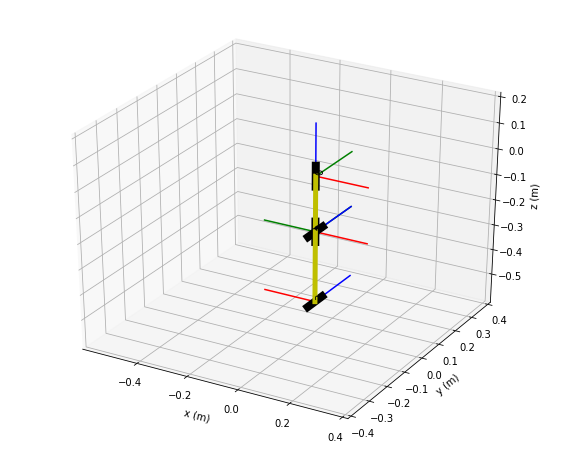

In [25]:
angle = [0, 0, 0, 0, 0, 0, 0, 0]
geom.draw_geom(angle)

In [26]:
geom.T_0n[2]

⎡-sin(q₂)⋅cos(q₁)  -cos(q₁)⋅cos(q₂)  -sin(q₁)     0    ⎤
⎢                                                      ⎥
⎢-sin(q₁)⋅sin(q₂)  -sin(q₁)⋅cos(q₂)  cos(q₁)      0    ⎥
⎢                                                      ⎥
⎢    -cos(q₂)          sin(q₂)          0      -0.21537⎥
⎢                                                      ⎥
⎣       0                 0             0         1    ⎦

## Create dynamics

In [27]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/3
Calculating the link kinetic energy of 2/3
Calculating the link kinetic energy of 3/3
Calculating joint torques...
dk_ddq_dtt:
dk_ddq_dt:
dL_dq:
dk_ddq_dtt:
dk_ddq_dt:
dL_dq:
dk_ddq_dtt:
dk_ddq_dt:
dL_dq:
Adding frictions, motor rotor inertia and springs...
Calculating gregressor...
('input_vars', (q1, q2, q3, dq1, dq2, dq3, ddq1, ddq2, ddq3))
Calculating M, C and G...
Calculating base parameter...
base parameter number: 26
Creating H_b function...
Finished creating robot dynamics
CPU times: user 1min 19s, sys: 317 ms, total: 1min 19s
Wall time: 1min 18s


In [1]:
dyn.tau

NameError: name 'dyn' is not defined

In [104]:
sympy.Matrix(dyn.base_param)

⎡                  1.0⋅l3y                   ⎤
⎢                                            ⎥
⎢                  1.0⋅l3x                   ⎥
⎢                                            ⎥
⎢                  1.0⋅L3xy                  ⎥
⎢                                            ⎥
⎢             1.0⋅l2x + 0.279⋅m₃             ⎥
⎢                                            ⎥
⎢                  1.0⋅L3yz                  ⎥
⎢                                            ⎥
⎢                  1.0⋅l2y                   ⎥
⎢                                            ⎥
⎢                  1.0⋅L3xz                  ⎥
⎢                                            ⎥
⎢                  1.0⋅L2xy                  ⎥
⎢                                            ⎥
⎢1.0⋅L1zz + 1.0⋅L2yy + 1.0⋅L3yy + 0.077841⋅m₃⎥
⎢                                            ⎥
⎢                  1.0⋅L3zz                  ⎥
⎢                                            ⎥
⎢                  1.0⋅L2yz                  ⎥
⎢            

In [4]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
'Yes DONE'

NameError: name 'dyn' is not defined

---
# 3 - Excitation trajectory optimization

Load Data

In [5]:
model_name = 'test_mtm'
model_folder = 'data/' + model_name + '/model/'

robot_model = load_data(model_folder, model_name)


## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [6]:
optimal_trajectory_folder = 'data/optimal_trajectory/'


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
trajectory_name = 'one'

base_freq = 0.1
fourier_order = 6

traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=[(q1, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi),
                                                  (q2, -np.pi/2, np.pi/2, -2*np.pi, 2*np.pi)],
                               cartesian_constraints = [(1,'max',1,0.4,1),
                                                        (1,'min',-1,-1,-1),
                                                        (2,'max',1,0.4,1),
                                                        (2,'min',-1,-1,-1) ])
                                                                                                                      
                                                                                                                     
traj_optimizer.optimize()

joint constraint number: 2
cartesian constraint number: 4
constraint number: 32
frames_constrained: [1. 2.]
Condition number: 23.0254997506
x: [ 0.00901442  0.19947961  0.76919162 -0.0255141   0.07424784  0.91539566
  0.01483558  0.07695808 -0.62413622 -0.61247719 -0.06520551 -0.35009052
 -0.82171211  0.28434987  0.25582062 -0.78205207  0.85596198  0.24178579
  0.88435971  0.60193834 -0.12301687  0.99695477 -0.01234458  0.94851251
  0.94857566  0.45966856  1.89933763  0.61355799  0.35188961 -0.88811353
 -0.29433427 -0.45691121 -0.73880049 -0.96945587  0.72714535 -0.03202744
  0.72270063 -0.7923478  -0.70403363]

SLSQP Solution to Optimial Excitation Trajectory

        Objective Function: _obj_func

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   15.7925
    Total Function Evaluations:          
    Sensitivities:        FD

    Objectives:
        Name        Value        Optimum
	     f         23.0255 

## Plot optimal excitation trajectory

In [7]:
traj_optimizer.calc_frame_traj()
#print(traj_optimizer.frame_traj[0])

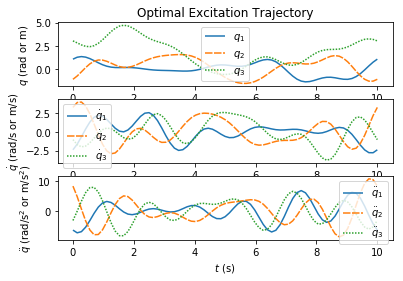

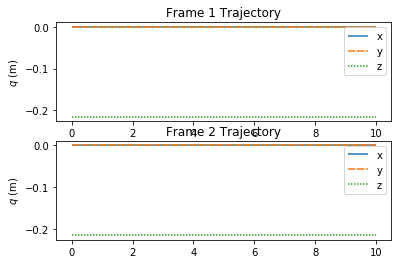

In [8]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj, traj_optimizer.const_frame_ind)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [9]:
dof_order_bf_x = (traj_optimizer.fourier_traj.dof, fourier_order, base_freq, traj_optimizer.x_result)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x)


---
# Data processing

In [10]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, gen_regressor

## Load data

In [11]:
# Names as Arguments
model_name = 'test_mtm'
trajectory_name = 'one'

# Folders Standard
model_folder = 'data/' + model_name + '/model/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
results_folder = 'data/' + model_name +'/measured_trajectory/'
results_data_file = results_folder + trajectory_name + '.csv'

# Load Results
trajectory_sampling_rate = 200
t, q_raw, tau_raw = load_trajectory_data(results_data_file, trajectory_sampling_rate)
dof = q_raw.shape[1]

# Load Robot Model
robot_model = load_data(model_folder,model_name)

(<type 'numpy.ndarray'>, (6000, 6))


## Calculate filter cut-off frequency

In [12]:
fc_mult = 10.0
wf = 0.1
order = 5
fc = wf * order * fc_mult
print("cut frequency is {}".format(fc))

cut frequency is 5.0


## Get velocity and acceleration data and filter raw data

q_raw shape: (6000, 3)
0
1
2
plot shape: 430


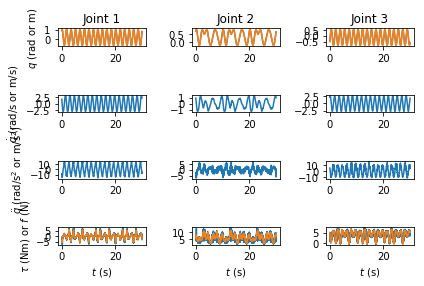

In [13]:
t_cut, q_f, dq_f, ddq_f, tau_f, q_raw_cut, tau_raw_cut = diff_and_filt_data(dof, 1.0/trajectory_sampling_rate, t,
                                                                        q_raw, tau_raw, fc, fc, fc, fc)
plot_trajectory_data(t_cut, q_raw_cut, q_f, dq_f, ddq_f, tau_raw_cut, tau_f)

In [14]:
#traj_optimizer.x_result # not part of workflow

---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [15]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b, tau_s = gen_regressor(base_param_num, H_b_func, q_f, dq_f, ddq_f, tau_f)

In [16]:
print(W_b.shape, tau_s.shape)

((17970, 26), (17970,))


In [17]:
xb_ols = np.linalg.lstsq(W_b, tau_s)[0]

/home/yan/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [18]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

⎡                  1.0⋅l3y                      0.0847755942816111  ⎤
⎢                                                                   ⎥
⎢                  1.0⋅l3x                        0.4419548562085   ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xy                     -0.0196864955290196 ⎥
⎢                                                                   ⎥
⎢             1.0⋅l2x + 0.279⋅m₃                 0.835140229573808  ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3yz                     0.00266376112181705 ⎥
⎢                                                                   ⎥
⎢                  1.0⋅l2y                      -0.0146356399025546 ⎥
⎢                                                                   ⎥
⎢                  1.0⋅L3xz                    -0.000232828742659522⎥
⎢                                                                   ⎥
⎢                  1

## Compare measured torque and predicted torque

### Generate predicted torque

In [19]:
tau_p = np.zeros(tau_f.shape)
tau_ps = W_b.dot(xb_ols)
for i in range(dof):
    tau_p[:, i] = tau_ps[i::dof]
    

### Evaluate regression

In [20]:
var_regression_error_ols = np.linalg.norm(tau_ps - tau_s) / (tau_ps.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols * np.linalg.inv(W_b.transpose().dot(W_b))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.0022604870305834666
standard deviation of xb using OLS:
[2.76023101e-04 3.68824828e-04 7.70562374e-05 8.13730390e-04
 1.86599419e-04 1.88938302e-03 9.35314606e-05 1.82846861e-04
 8.22315691e-04 1.39796712e-04 2.59895208e-04 1.98993507e-04
 4.68477750e-04 1.68818597e-03 1.02992634e-02 8.12403190e-04
 1.16285739e-03 1.65703848e-04 8.60185846e-04 4.86466225e-04
 3.21226390e-03 1.83827719e-02 2.32981152e-03 1.40169704e-03
 1.68863471e-03 1.35801454e-03]
percentage of standard deviation of xb using OLS: 
[3.25592646e-03 8.34530547e-04 3.91416732e-03 9.74363779e-04
 7.00511082e-02 1.29094664e-01 4.01717844e-01 2.42817900e-01
 2.07157326e-03 1.04577743e-03 2.63555736e-01 1.48193194e-01
 1.75741961e-03 1.05305815e-01 2.88095522e-02 5.33826657e-02
 5.02903368e-02 1.40035026e-02 2.96557893e-03 2.71953483e-03
 3.12322555e-02 5.05812464e-02 2.76207066e-02 6.60108909e-02
 5.18185647e-02 5.98295533e+00]


### Plot measured torque and predicted torque

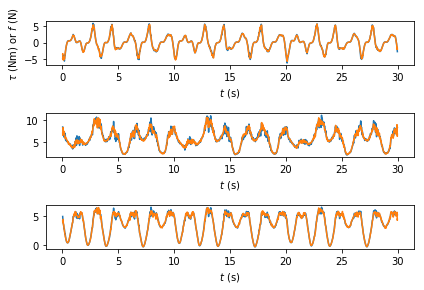

In [21]:
plot_meas_pred_tau(t_cut, tau_f, tau_p)

## Weighted Least Square (WLS)

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [22]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W, tau_s = gen_regressor(bary_param_num, H_func, q_f, dq_f, ddq_f, tau_f)

In [23]:
len(robot_model.std_param)

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [24]:
# constraint order: (min_m, max_m, min_x, max_x, min_y, max_y, min_z, max_z)
# sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
#                   (0.5, 3, -0.1, 0.1, -0.1, 0.1, -0.05, 0.05),
#                   (0.5, 5, 0, 0.3, 0, 0.1, -0.05, 0.05),
#                   (0.5, 5, -0.1, 0.1, 0, 0.1, -0.1, 0.1),
#                   (0.1, 1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1),]
sdp_constraints = [(1, 10, -0.05, 0.05, 0, 0.1, 0, 0.2),
                  (0.5, 10, -0.2, 0.2, -0.2, 0.2, -0.05, 0.05),
                  (0.5, 10, 0, 0.3, 0, 0.1, -0.05, 0.05)]

sdp_constraints = [(0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 2, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01),
                  (0.1, 3, -0.5, 0.5, -0.5, 0.5, -0.5, 0.5, 0.01, 0.01, 0.01)]
spring_constraints = [(0.05, 0.2)]

In [25]:
sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints, spring_constraints)
sdp_opt_std.solve()

Regressor shape: (17970, 41)
Regressand shape: (17970,)
Creating variables...
Creating optimization objective...
Creating constraints...
Ia3 param40
Solving problem...
[ 5.09445198e-06  0.00000000e+00  0.00000000e+00  5.09445198e-06
  0.00000000e+00  1.17624267e-05  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.01690364e+00  2.58740911e-03  4.27533539e-03
 -4.69135754e-03  1.68203923e-02  1.25055656e-03  1.08592020e-03
  1.49184085e-01  4.29552580e-04  1.25384476e-01  3.99513003e-01
  1.37321591e-03 -7.96628651e-03  2.99834172e+00  6.53430733e-03
  5.85218812e-03  9.34327702e-03  3.62805112e-02 -2.06936294e-02
 -1.02322167e-03  1.39551625e-01  1.53003529e-03  1.24569578e-01
  4.52905246e-01  7.94908476e-02  2.36500650e-03  1.69297178e+00
  1.31110275e-02  3.47722232e-03 -2.12916722e-03  7.33309757e-04
  5.04030191e-02]


In [26]:
len(sdp_opt_std._constraints)

## Compare measured torque and predicted torque

### Generate predicted torque

In [27]:
tau_sdp_p = np.zeros(tau_f.shape)
tau_sdp_ps = W.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_sdp_p[:, i] = tau_sdp_ps[i::dof]

### Plot measured torque and predicted torque

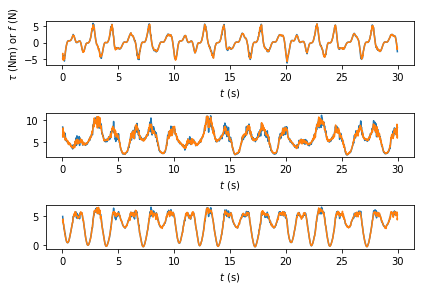

In [28]:
plot_meas_pred_tau(t_cut, tau_f, tau_sdp_p)

In [29]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))

⎡L1xx  5.09445198078853e-6 ⎤
⎢                          ⎥
⎢L1xy          0.0         ⎥
⎢                          ⎥
⎢L1xz          0.0         ⎥
⎢                          ⎥
⎢L1yy  5.09445198078853e-6 ⎥
⎢                          ⎥
⎢L1yz          0.0         ⎥
⎢                          ⎥
⎢L1zz  1.17624267464059e-5 ⎥
⎢                          ⎥
⎢l1x           0.0         ⎥
⎢                          ⎥
⎢l1y           0.0         ⎥
⎢                          ⎥
⎢l1z           0.0         ⎥
⎢                          ⎥
⎢ m₁     1.01690364065353  ⎥
⎢                          ⎥
⎢Fc₁    0.0025874091067571 ⎥
⎢                          ⎥
⎢Fv₁    0.0042753353883042 ⎥
⎢                          ⎥
⎢Fo₁   -0.00469135753873988⎥
⎢                          ⎥
⎢L2xx   0.0168203923422883 ⎥
⎢                          ⎥
⎢L2xy  0.00125055656359223 ⎥
⎢                          ⎥
⎢L2xz  0.00108592020198021 ⎥
⎢                          ⎥
⎢L2yy   0.149184084837292  ⎥
⎢                          ⎥
⎢L2yz  0.00042

In [30]:
from identification import barycentric2standard_params

In [31]:
sdp_opt_std.x_result

array([ 5.09445198e-06,  0.00000000e+00,  0.00000000e+00,  5.09445198e-06,
        0.00000000e+00,  1.17624267e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.01690364e+00,  2.58740911e-03,  4.27533539e-03,
       -4.69135754e-03,  1.68203923e-02,  1.25055656e-03,  1.08592020e-03,
        1.49184085e-01,  4.29552580e-04,  1.25384476e-01,  3.99513003e-01,
        1.37321591e-03, -7.96628651e-03,  2.99834172e+00,  6.53430733e-03,
        5.85218812e-03,  9.34327702e-03,  3.62805112e-02, -2.06936294e-02,
       -1.02322167e-03,  1.39551625e-01,  1.53003529e-03,  1.24569578e-01,
        4.52905246e-01,  7.94908476e-02,  2.36500650e-03,  1.69297178e+00,
        1.31110275e-02,  3.47722232e-03, -2.12916722e-03,  7.33309757e-04,
        5.04030191e-02])

In [32]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)

In [33]:
sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))

⎡I1xx   5.09445198078853e-6 ⎤
⎢                           ⎥
⎢I1xy            0          ⎥
⎢                           ⎥
⎢I1xz            0          ⎥
⎢                           ⎥
⎢I1yy   5.09445198078853e-6 ⎥
⎢                           ⎥
⎢I1yz            0          ⎥
⎢                           ⎥
⎢I1zz   1.17624267464059e-5 ⎥
⎢                           ⎥
⎢r1x            0.0         ⎥
⎢                           ⎥
⎢r1y            0.0         ⎥
⎢                           ⎥
⎢r1z            0.0         ⎥
⎢                           ⎥
⎢ m₁     1.01690364065353   ⎥
⎢                           ⎥
⎢Fc₁    0.0025874091067571  ⎥
⎢                           ⎥
⎢Fv₁    0.0042753353883042  ⎥
⎢                           ⎥
⎢Fo₁   -0.00469135753873988 ⎥
⎢                           ⎥
⎢I2xx   0.0167985978141927  ⎥
⎢                           ⎥
⎢I2xy   0.00143353024151364 ⎥
⎢                           ⎥
⎢I2xz   2.44551156013252e-5 ⎥
⎢                           ⎥
⎢I2yy   0.0959299475728622  ⎥
⎢         

In [47]:
sympy.cse(dyn.H_b*sympy.Matrix(dyn.base_param))

⎛                                                                             
⎜⎡                                                              ⎛       2⎞    
⎜⎢(x₀, 1.0⋅L2xx), (x₁, 1.0⋅L3yy), (x₂, sin(q₂)), (x₃, cos(q₂)), ⎝x₄, dq₂ ⎠, (x
⎜⎣                                                                            
⎝                                                                             

                                                                              
                                                                              
₅, 1.0⋅L2yz), (x₆, 2⋅q₂), (x₇, sin(x₆)), (x₈, cos(x₆)), (x₉, 2⋅dq₂), (x₁₀, 1.0
                                                                              
                                                                              

                                                                              
                                                                              
⋅L2xy), (x₁₁, 1.0⋅L2xz - 0.279⋅l3z), (x₁₂, 2⋅q₃ + 